In [63]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil
import warnings
warnings.filterwarnings('ignore')

In [8]:
fs=glob('/data4/Ukraine_img/M_and_L/*tif')
for f in fs:
    ds=gdal.Open(f)
    # img=ds.ReadAsArray()
    # print(img.shape)
    print(ds.GetGeoTransform())
trf_big=gdal.Open(fs[0]).GetGeoTransform()
shape_big=gdal.Open(fs[0]).ReadAsArray().shape

(37.461454146823876, 0.0001796630568239043, 0.0, 47.22200903489612, 0.0, -0.0001796630568239043)
(37.461454146823876, 0.0001796630568239043, 0.0, 47.22200903489612, 0.0, -0.0001796630568239043)
(37.46136431529546, 8.983152841195215e-05, 0.0, 47.22209886642453, 0.0, -8.983152841195215e-05)
(37.46136431529546, 8.983152841195215e-05, 0.0, 47.22209886642453, 0.0, -8.983152841195215e-05)
(37.461454146823876, 0.0001796630568239043, 0.0, 47.22200903489612, 0.0, -0.0001796630568239043)
(37.46136431529546, 8.983152841195215e-05, 0.0, 47.22209886642453, 0.0, -8.983152841195215e-05)
(37.461454146823876, 0.0001796630568239043, 0.0, 47.22200903489612, 0.0, -0.0001796630568239043)
(37.461454146823876, 0.0001796630568239043, 0.0, 47.22200903489612, 0.0, -0.0001796630568239043)
(37.46136431529546, 8.983152841195215e-05, 0.0, 47.22209886642453, 0.0, -8.983152841195215e-05)
(37.461454146823876, 0.0001796630568239043, 0.0, 47.22200903489612, 0.0, -0.0001796630568239043)
(37.461454146823876, 0.00017966305

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [64]:
def get_mask(maskshp,geotrf,shape,p='4326'):
    img=np.zeros((shape[0],shape[1]))
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    
    trf=(geotrf[0], geotrf[1], geotrf[2], geotrf[3], geotrf[4], geotrf[5])
    drv = gdal.GetDriverByName('MEM')
    dst = drv.Create('', shape[1], shape[0], 1, gdal.GDT_UInt16)

    sp = dst.SetProjection(proj)
    sg = dst.SetGeoTransform(trf)

    wa = dst.GetRasterBand(1).WriteArray(img)
    del wa, sg, sp
    img_bob = GeoImg(dst)
    mask = create_mask_from_shapefile(img_bob, maskshp)
    return mask
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def tif_save_bands(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[2],img.shape[1],img.shape[0],6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    for i in range(img.shape[0]):
        new_img.GetRasterBand(i+1).WriteArray(img[i,:,:])
    new_img.FlushCache()
    del new_img
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img

# 分区mask

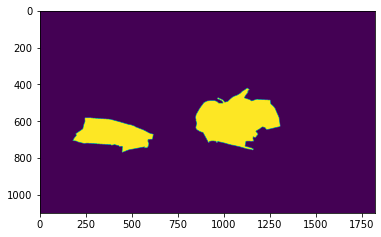

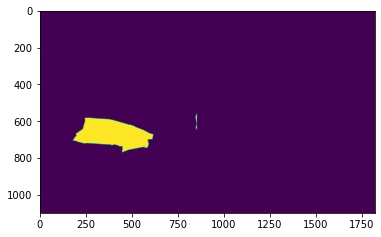

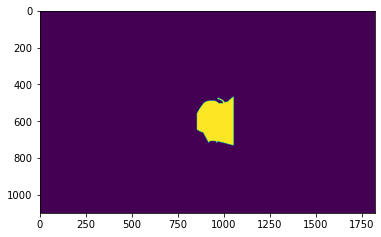

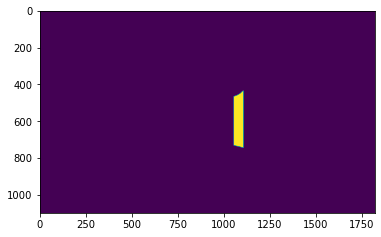

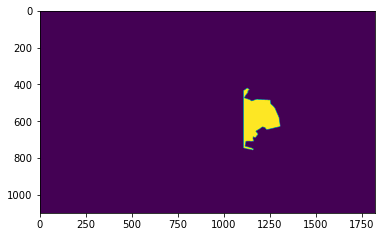

In [10]:
fs10=glob('/data4/Ukraine_img/U_band2348/*reprojection.tif')
ds=gdal.Open(fs10[0])
    # img=ds.ReadAsArray()
    # print(img.shape)
trf_small=ds.GetGeoTransform()
k=[528+529,673*2,711*2]
k=[trf_small[0]+trf_small[1]*i for i in k]
k=[round((i-trf_big[0])/trf_big[1]) for i in k]
k
mask_area1=np.zeros((shape_big[1],shape_big[2]))
mask_area1[:,:k[0]]=1
mask_area2=np.zeros((shape_big[1],shape_big[2]))
mask_area2[:,k[0]:k[1]]=1
mask_area3=np.zeros((shape_big[1],shape_big[2]))
mask_area3[:,k[1]:k[2]]=1
mask_area4=np.zeros((shape_big[1],shape_big[2]))
mask_area4[:,k[2]:]=1
masks_area=[mask_area1,mask_area2,mask_area3,mask_area4]

L_mask=get_mask('/home/hk/python_script/Ukraine/data/UNOSAT/U/UNOSAT_Mariupol_Livoberezhyny_AOI_12May2022.shp',trf_big,[shape_big[1],shape_big[2]],p='4326')
plt.imshow(L_mask)
plt.show()
for i in masks_area:
    i[(i==1) & (L_mask==0)]=0
for i in masks_area:
    plt.imshow(i)
    plt.show()
# torch.save(masks_area,'/home/hk/python_script/Ukraine/data/UNOSAT/U/area_mask_big.pth')

In [12]:
fs10=glob('/data4/Ukraine_img/M_and_L/*.tif')
date=[os.path.basename(i)[:8] for i in fs10]
date=list(set(date))
date.sort()
fs_datedict={}
for d in date:
    fs_datedict[d]=glob(f'/data4/Ukraine_img/M_and_L/{d}*.tif')
labels_date={'area1':{'A':['20210910'],'A-B':['20220227','20220309'],'B':['20220314'],'B-C':['20220319','20220324','20220329','20220403','20220428','20220503','20220508'],'C':[],'C-Z':['20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']},
            'area2':{'A':['20210910'],'A-B':['20220227','20220309'],'B':['20220314'],'B-C':['20220319','20220324','20220329','20220403','20220428','20220503'],'C':['20220508'],'C-Z':['20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']},
            'area3':{'A':['20210910'],'A-B':['20220227','20220309'],'B':['20220314'],'B-Z':['20220319','20220324','20220329','20220403','20220428','20220503','20220508','20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']},
            'area4':{'A':['20210910'],'A-B':['20220227','20220309'],'B':['20220314'],'B-C':['20220319','20220324','20220329','20220403','20220428','20220503'],'C':[],'C-Z':['20220508','20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']}
                    }
points_path={'area1':{'B':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','C':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12.shp'},
            'area2':{'B':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','C':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08.shp'},
            'area3':{'B':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','C':None},
            'area4':{'B':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','C':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07.shp'},
                }

In [13]:
fs10=glob('/data4/Ukraine_img/M_and_L/*.tif')
fs10=[i for i in fs10 if i[-5:]!='r.tif']
fs10.sort()
fs10

['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif',
 '/data4/Ukraine_img/M_an

# 转换图像为Patch

In [101]:
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def get_patch(data,size):
    img=data['img']
    trf=data['trf']
    shape=img.shape
    img=np.pad(img,((0,0),(0,size-shape[1]%size),(0,size-shape[2]%size)),'constant',constant_values=0)
    shape=img.shape
    img=img.reshape([shape[0],int(shape[1]/size),-1,shape[2]])
    shape=img.shape
    img=img.reshape([shape[0],shape[1],shape[2],int(shape[3]/size),-1])
    return {'img':img.transpose((0,1,3,2,4)),'trf':(trf[0]-trf[1]/2,trf[1]*size,trf[2],trf[3]-trf[5]/2,trf[4],trf[5]*size)}

size=6
img_pathes=fs10
# img_pathes=['/data2/Syria_img/Raqqa_enhance-A-B-4_20130213_treated.tif']
print(img_pathes)
for mask_id in [0,1,2,3]:
    mask=masks_area[mask_id]
    for path in img_pathes:
        # try:    


    
        print(path)
        data=read_img(path)
        data['img']=data['img'][:4]
        ddata=read_img(path.replace('.tif','_bandother.tif'))
        for i in range(4):
            data['img'][i,:,:][mask==0]=0
        print(data['img'].shape)
        data2=get_patch(data,6)
        ddata2=get_patch(ddata,3)
        print(data2['img'].shape)
        print(data2['trf'])
        d=data2['img'].astype(np.int16)
        dd=ddata2['img'].astype(np.int16)
        info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度',
        'trf':data2['trf'],'shape':[data['img'].shape,d.shape],'img10':d,'img20':dd}

        # np.save(path.replace('.tif',f'_size_{size}.npy'),d)
        print('max:',d.max())
        torch.save(info,path.replace('.tif',f'_size_{size}_area{mask_id+1}_info.pth'))
        del data,data2,d
        gc.collect()
        # except:
        #         print('ERROR',path)

['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN.tif', '/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220602T0

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5040
/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4684
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6756
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5748
/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6780
/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6036
/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5996
/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6380
/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6292
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6224
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7208
/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 9048
/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 9088
/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 8188
/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 11368
/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 11536
/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7532
/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7264
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5152
/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5976
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6192
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6900
/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5368
/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6560
/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6516
/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6472
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6376
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7832
/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7836
/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7484
/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7740
/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 8392
/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 9592
/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4476
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4660
/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4264
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6412
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4852
/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4452
/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4796
/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6636
/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5940
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6972
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7584
/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6716
/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6504
/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 9288
/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6664
/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6796
/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6084
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4000
/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6112
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6820
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 17840
/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4124
/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6380
/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5960
/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 14152
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 10440
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7520
/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6664
/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2.tif
(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 10432
/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6900
/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6948
/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7724
/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 2196, 3638)
(4, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0


In [100]:
size=6
img_pathes=fs10
# img_pathes=['/data2/Syria_img/Raqqa_enhance-A-B-4_20130213_treated.tif']
print(img_pathes)

for path in img_pathes:
    # try:    
    
    print(path)
    data=read_img(path)
    ddata=read_img(path.replace('.tif','_bandother.tif'))
    print(data['img'].shape)
    data2=get_patch(data,6)
    ddata2=get_patch(ddata,3)
    print(data2['img'].shape)
    print(data2['trf'])
    d=data2['img'][:4].astype(np.int16)
    dd=ddata2['img'].astype(np.int16)
    info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度',
    'trf':data2['trf'],'shape':[data['img'].shape,d.shape],'img10':d,'img20':dd}

    # np.save(path.replace('.tif',f'_size_{size}.npy'),d)
    print('max:',d.max())
    torch.save(info,path.replace('.tif',f'_size_{size}_areaall_info.pth'))
    del data,data2,d
    gc.collect()
    # except:
    #         print('ERROR',path)

['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN.tif', '/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220602T0

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5676
/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif
(10, 2196, 3638)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 9200
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 17328
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 17840
/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 15104
/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 18704
/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif
(10, 2196, 3638)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 9976
/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif
(10, 2196, 3638)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 8608
/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 19568
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 18416
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif
(10, 2196, 3638)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 18640
/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 17232
/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 16752
/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 19120
/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 18224
/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 22448
/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2.tif
(10, 2196, 3638)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 9312
/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2.tif
(10, 2196, 3638)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 8064


In [12]:
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def get_patch(data,size):
    img=data['img']
    trf=data['trf']
    shape=img.shape
    img=np.pad(img,((0,0),(0,size-shape[1]%size),(0,size-shape[2]%size)),'constant',constant_values=0)
    shape=img.shape
    img=img.reshape([shape[0],int(shape[1]/size),-1,shape[2]])
    shape=img.shape
    img=img.reshape([shape[0],shape[1],shape[2],int(shape[3]/size),-1])
    return {'img':img.transpose((0,1,3,2,4)),'trf':(trf[0]-trf[1]/2,trf[1]*size,trf[2],trf[3]-trf[5]/2,trf[4],trf[5]*size)}
path='/data4/Ukraine_img/ESRI_Global-LULC_10m.tif'
print(path)
data=read_img(path)
data['img']=np.expand_dims(data['img'], 0)
# ddata=read_img(path.replace('.tif','_bandother.tif'))
print(data['img'].shape)
data2=get_patch(data,6)

print(data2['img'].shape)
print(data2['trf'])
d=data2['img'][:4].astype(np.int16)

info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度',
'trf':data2['trf'],'shape':[data['img'].shape,d.shape],'img10':d}

# np.save(path.replace('.tif',f'_size_{size}.npy'),d)
print('max:',d.max())
torch.save(info,path.replace('.tif',f'_patch_info.pth'))
del data,data2,d
gc.collect()

/data4/Ukraine_img/ESRI_Global-LULC_10m.tif
(1, 2196, 3638)
(1, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 8


51

# 制作patch的label

In [66]:
labels_date

{'area1': {'A': ['20210910'],
  'A-B': ['20220227', '20220309'],
  'B': ['20220314'],
  'B-C': ['20220319',
   '20220324',
   '20220329',
   '20220403',
   '20220428',
   '20220503',
   '20220508'],
  'C': [],
  'C-Z': ['20220523',
   '20220528',
   '20220602',
   '20220607',
   '20220612',
   '20220617',
   '20220622',
   '20220627']},
 'area2': {'A': ['20210910'],
  'A-B': ['20220227', '20220309'],
  'B': ['20220314'],
  'B-C': ['20220319',
   '20220324',
   '20220329',
   '20220403',
   '20220428',
   '20220503'],
  'C': ['20220508'],
  'C-Z': ['20220523',
   '20220528',
   '20220602',
   '20220607',
   '20220612',
   '20220617',
   '20220622',
   '20220627']},
 'area3': {'A': ['20210910'],
  'A-B': ['20220227', '20220309'],
  'B': ['20220314'],
  'B-Z': ['20220319',
   '20220324',
   '20220329',
   '20220403',
   '20220428',
   '20220503',
   '20220508',
   '20220523',
   '20220528',
   '20220602',
   '20220607',
   '20220612',
   '20220617',
   '20220622',
   '20220627']},
 'area4

In [65]:
img_pathes={}

for area in labels_date.keys():
    k={}
    for date_id in labels_date[area].keys():
        date_list=labels_date[area][date_id]
        fl=[]
        for d in date_list:
            fl+=glob(f'/data4/Ukraine_img/M_and_L/{d}*{area}*.pth')
        k[date_id]=fl
    img_pathes[area]=k
img_pathes

{'area1': {'A': ['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area1_info.pth'],
  'A-B': ['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area1_info.pth'],
  'B': ['/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area1_info.pth'],
  'B-C': ['/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukra

In [15]:
def get_dam_mask(point,patch_file,weight):
    trf=torch.load(patch_file)['trf']
    shape=torch.load(patch_file)['shape'][1]
    p_coor=[shapely.geometry.mapping(list(point)[i])['coordinates'] for i in range(len(point))]
    mask=np.zeros((shape[1],shape[2]))
    p_x_y=[[int((i[0]-trf[0])/trf[1]),int((i[1]-trf[3])/trf[5])] for i in p_coor]
    for i in p_x_y:
        try:
            mask[i[1],i[0]]+=weight
        except:
            pass
    return mask
def get_mask(points_path,patch_path):
    n=points_path.split("_")[-2]
    df=gpd.read_file(points_path)
    print(len(df))
    point_num={}
    point=df[df['DmgCls']=='Destroyed']['geometry']
    point_num['destroyed']=len(point)
    print('destroyed:',len(point))
    mask_destroyed=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Severe Damage']['geometry']
    point_num['severe']=len(point)
    print('Severe Damage:',len(point))
    mask_severe=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Moderate Damage']['geometry']
    point_num['moderate']=len(point)
    print('Moderate Damage:',len(point))
    mask_moderate=get_dam_mask(point,patch_path,1)

    mask=mask_destroyed*6+mask_severe*3+mask_moderate
    date=df['SensDt'][0]
    print(f'{n}  {date}得分',dict(Counter(list(mask.flatten()))))
    mask_type=np.zeros(mask.shape)
    mask_type[mask>0]=1
    mask_type[mask>=6]=2
    print(f'{date}损毁类型',Counter(list(mask_type.flatten())))
    all_mask=[mask_destroyed,mask_severe,mask_moderate,mask,mask_type]
    info='5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
    result={'info':info,'point_num':point_num,'mask':all_mask}
    return result

In [58]:
points_list=['/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08.shp','/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07.shp']
for point_path in points_list:
    patch_path='/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area4_info.pth'
    result=get_mask(point_path,patch_path)
    torch.save(result,point_path.replace('.shp','_size_6_dammask.pth.tar').replace('/home/hk/python_script/Ukraine/data/UNOSAT/U/','/data4/Ukraine_img/M_and_L/'))
    print('__________________________SAVE SUCCESS__________________________')

# for point_path in points_list:
#     patch_path='/data4/Ukraine_img/U_bandother/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_3_info.pth'
#     result=get_mask(point_path,patch_path)
#     torch.save(result,point_path.replace('.shp','_size_3_dammask.pth.tar'))
#     print('__________________________SAVE SUCCESS__________________________')


750
destroyed: 61
Severe Damage: 300
Moderate Damage: 311
B  2022-03-14得分 {0.0: 222218, 3.0: 192, 6.0: 58, 1.0: 229, 4.0: 18, 9.0: 14, 7.0: 8, 2.0: 19, 14.0: 1, 5.0: 5, 12.0: 3, 10.0: 1, 21.0: 1, 11.0: 1, 15.0: 1}
2022-03-14损毁类型 Counter({0.0: 222218, 1.0: 463, 2.0: 88})
__________________________SAVE SUCCESS__________________________
2919
destroyed: 168
Severe Damage: 930
Moderate Damage: 1697
C-Area1  2022-05-12得分 {0.0: 221072, 3.0: 257, 1.0: 818, 5.0: 43, 4.0: 124, 2.0: 136, 11.0: 7, 7.0: 54, 16.0: 7, 15.0: 6, 6.0: 105, 12.0: 16, 9.0: 51, 8.0: 13, 14.0: 6, 13.0: 12, 10.0: 22, 28.0: 1, 19.0: 3, 18.0: 7, 32.0: 1, 17.0: 1, 27.0: 2, 24.0: 1, 21.0: 3, 20.0: 1}
2022-05-12损毁类型 Counter({0.0: 221072, 1.0: 1378, 2.0: 319})
__________________________SAVE SUCCESS__________________________
1826
destroyed: 87
Severe Damage: 789
Moderate Damage: 909
C-Area2  2022-05-08得分 {0.0: 221612, 3.0: 315, 1.0: 463, 6.0: 93, 2.0: 65, 4.0: 79, 9.0: 25, 7.0: 24, 10.0: 20, 16.0: 3, 13.0: 9, 5.0: 19, 8.0: 14, 15.0

In [16]:
dammasks_path={}
for i in points_path.keys():
    k={}
    k['A']=None
    for j in points_path[i].keys():
        if points_path[i][j] is not None:
            k[j]=points_path[i][j].replace('.shp','_size_6_dammask.pth.tar') \
            .replace('/home/hk/python_script/Ukraine/data/UNOSAT/U/','/data4/Ukraine_img/M_and_L/')
            if not os.path.exists(k[j]):
                print('No file')
    k['Z']=None
    dammasks_path[i]=k
dammasks_path

{'area1': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'C': '/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1_2022-05-12_size_6_dammask.pth.tar',
  'Z': None},
 'area2': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'C': '/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area2_2022-05-08_size_6_dammask.pth.tar',
  'Z': None},
 'area3': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'Z': None},
 'area4': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'C': '/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1-4_2022-05-07_size_6_dammask.pth.tar',
  'Z': None}}

# 制作样本

In [20]:
# masks={
#     'A':None,
#     'B':glob(f'/data2/Syria_img/{city}_B_*_treated_size_120_dammask.pth.tar')[0],
#     'C':glob(f'/data2/Syria_img/{city}_C_*_treated_size_120_dammask.pth.tar')[0],
#     'D':glob(f'/data2/Syria_img/{city}_D_*_treated_size_120_dammask.pth.tar')[0],
#     'Z':None
# }


def get_samples(pre_patch,post_patch,dammask_after,dammask_now,dammask_before):
        # if pre_patch[0].shape!=post_patch[0].shape:
        #         raise('SHAPE ERROR')
        if pre_patch[0].shape[0]!=4 or post_patch[0].shape[0]!=4:
                raise
        if pre_patch[1].shape[0]!=6 or post_patch[1].shape[0]!=6:
                raise
                               
        shape=pre_patch[0].shape
        print(shape)
        zz=np.zeros((shape[1],shape[2]))
        samples=[]
        if dammask_now is not None:
                for x in range(shape[1]):
                        for y in range(shape[2]):
                                
                                if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                        continue
                                else:
                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_now['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                        zz[x,y]=1
        else:
                if dammask_before is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_after['mask'][0][x,y]==0:
                                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_after is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                # if dammask_before['mask'][0][x,y]>0:
                                                samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],None],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                zz[x,y]=1
                if dammask_before is not None and dammask_after is not None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if (dammask_after['mask'][0][x,y]>0 and dammask_before['mask'][0][x,y]>0) or (dammask_after['mask'][0][x,y]==0 and dammask_before['mask'][0][x,y]==0):
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                                        
        return samples,zz

In [17]:
img_pathes

{'area1': {'A': ['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area1_info.pth'],
  'A-B': ['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area1_info.pth'],
  'B': ['/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area1_info.pth'],
  'B-C': ['/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area1_info.pth',
   '/data4/Ukra

In [18]:
dammasks_path

{'area1': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'C': '/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1_2022-05-12_size_6_dammask.pth.tar',
  'Z': None},
 'area2': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'C': '/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area2_2022-05-08_size_6_dammask.pth.tar',
  'Z': None},
 'area3': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'Z': None},
 'area4': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'C': '/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1-4_2022-05-07_size_6_dammask.pth.tar',
  'Z': None}}

-------------------------------------
['A', 'A-B', 'B', 'B-C', 'C', 'C-Z']


A-B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: A-B
['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area1_info.pth']
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area1_info.pth


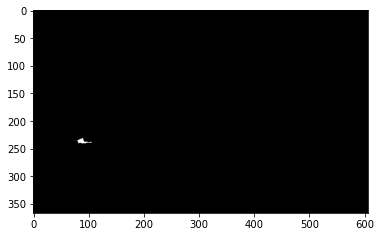

(4, 367, 607, 6, 6)
writing samples 84


100%|██████████| 84/84 [00:00<00:00, 69918.94it/s]


/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area1_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


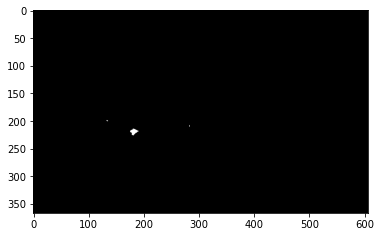

(4, 367, 607, 6, 6)
writing samples 78


100%|██████████| 78/78 [00:00<00:00, 68947.46it/s]




B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
load img: B
['/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area1_info.pth']
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area1_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


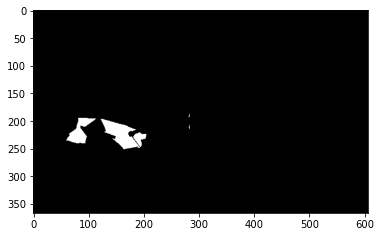

(4, 367, 607, 6, 6)
writing samples 2954


100%|██████████| 2954/2954 [00:00<00:00, 159944.93it/s]




B-C
loading mask: B and C
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1_2022-05-12_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: B-C
['/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_area1_info.pth']
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area1_info.pth


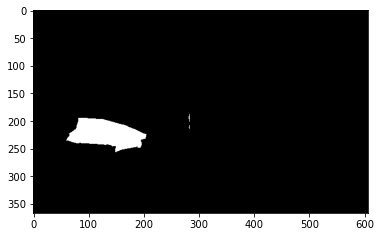

(4, 367, 607, 6, 6)
writing samples 5135


100%|██████████| 5135/5135 [00:00<00:00, 184795.67it/s]


/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area1_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


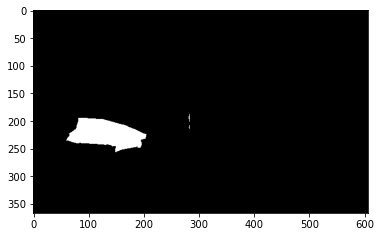

(4, 367, 607, 6, 6)
writing samples 5136


100%|██████████| 5136/5136 [00:00<00:00, 191499.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area1_info.pth


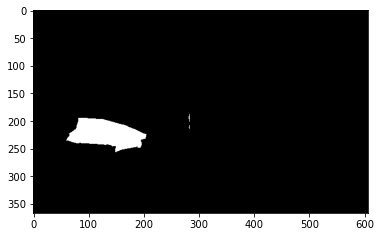

(4, 367, 607, 6, 6)
writing samples 5136


100%|██████████| 5136/5136 [00:00<00:00, 204611.86it/s]


/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area1_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


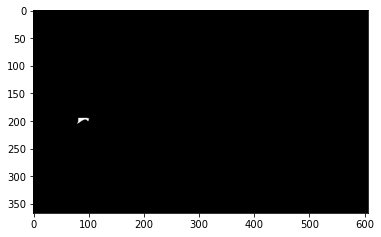

(4, 367, 607, 6, 6)
writing samples 76


100%|██████████| 76/76 [00:00<00:00, 66967.88it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area1_info.pth


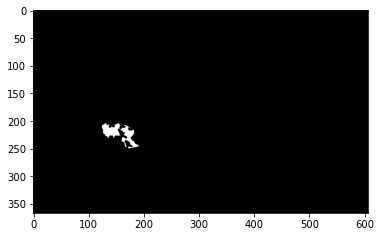

(4, 367, 607, 6, 6)
writing samples 898


100%|██████████| 898/898 [00:00<00:00, 114507.19it/s]


/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area1_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


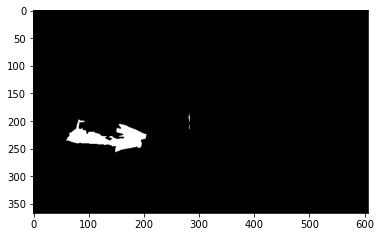

(4, 367, 607, 6, 6)
writing samples 3127


100%|██████████| 3127/3127 [00:00<00:00, 149351.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_area1_info.pth


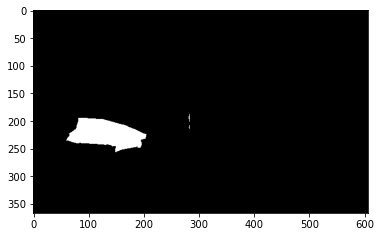

(4, 367, 607, 6, 6)
writing samples 5136


100%|██████████| 5136/5136 [00:00<00:00, 185154.16it/s]




C
loading mask: C
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1_2022-05-12_size_6_dammask.pth.tar


C-Z
loading mask: C
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1_2022-05-12_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: C-Z
['/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_area1_info.pth', '/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_area1_info.pth']
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area1_info.pth


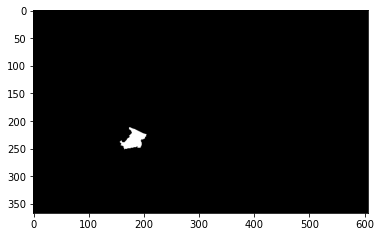

(4, 367, 607, 6, 6)
writing samples 878


100%|██████████| 878/878 [00:00<00:00, 118248.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_area1_info.pth


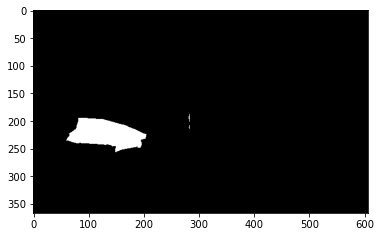

(4, 367, 607, 6, 6)
writing samples 5243


100%|██████████| 5243/5243 [00:00<00:00, 193759.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_area1_info.pth


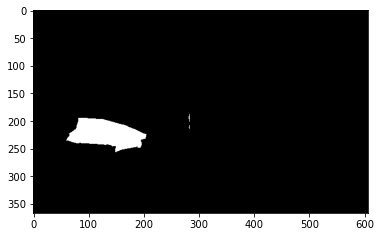

(4, 367, 607, 6, 6)
writing samples 5243


100%|██████████| 5243/5243 [00:00<00:00, 199287.12it/s]


/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_area1_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


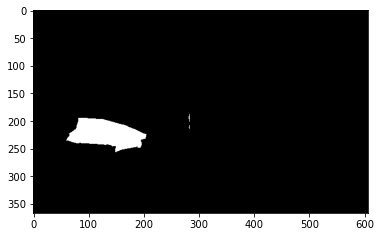

(4, 367, 607, 6, 6)
writing samples 5243


100%|██████████| 5243/5243 [00:00<00:00, 197680.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_area1_info.pth


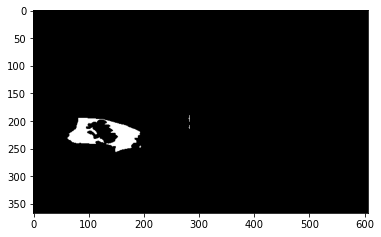

(4, 367, 607, 6, 6)
writing samples 3249


100%|██████████| 3249/3249 [00:00<00:00, 157519.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_area1_info.pth


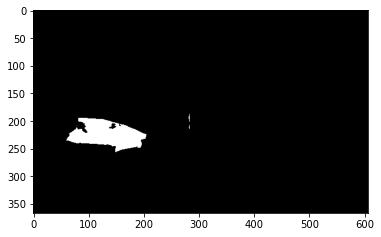

(4, 367, 607, 6, 6)
writing samples 4886


100%|██████████| 4886/4886 [00:00<00:00, 199989.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_area1_info.pth


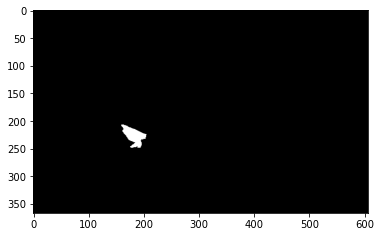

(4, 367, 607, 6, 6)
writing samples 868


100%|██████████| 868/868 [00:00<00:00, 119049.60it/s]


/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_area1_info.pth


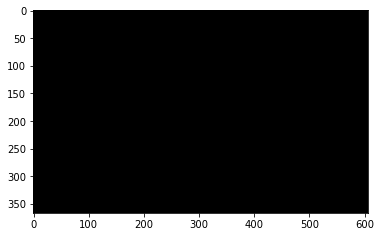

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


-------------------------------------
['A', 'A-B', 'B', 'B-C', 'C', 'C-Z']


A-B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: A-B
['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area2_info.pth']
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area2_info.pth


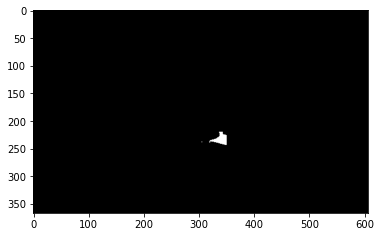

(4, 367, 607, 6, 6)
writing samples 318


100%|██████████| 318/318 [00:00<00:00, 100998.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area2_info.pth


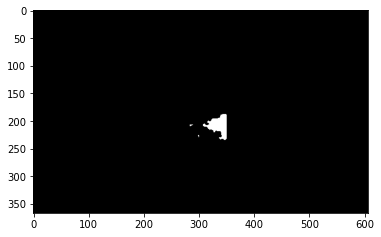

(4, 367, 607, 6, 6)
writing samples 923


100%|██████████| 923/923 [00:00<00:00, 114519.82it/s]




B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
load img: B
['/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area2_info.pth']
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


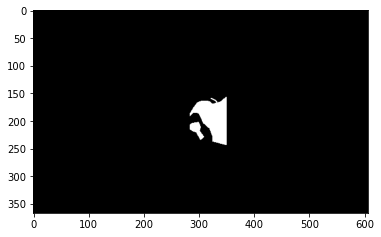

(4, 367, 607, 6, 6)
writing samples 3464


100%|██████████| 3464/3464 [00:00<00:00, 157635.09it/s]




B-C
loading mask: B and C
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area2_2022-05-08_size_6_dammask.pth.tar
load img: B-C
['/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area2_info.pth']
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


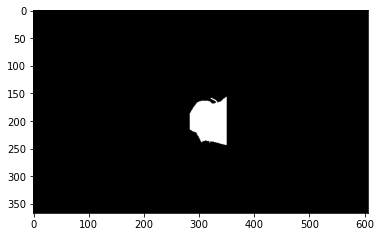

(4, 367, 607, 6, 6)
writing samples 4272


100%|██████████| 4272/4272 [00:00<00:00, 176228.83it/s]


/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


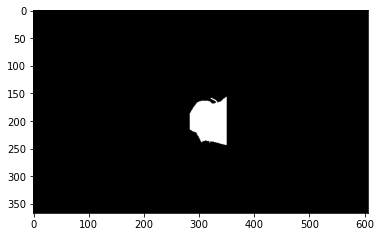

(4, 367, 607, 6, 6)
writing samples 4272


100%|██████████| 4272/4272 [00:00<00:00, 192070.52it/s]


/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


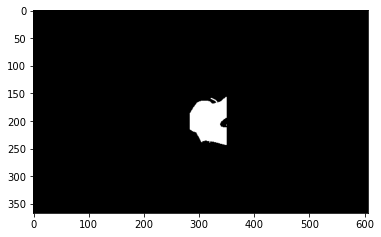

(4, 367, 607, 6, 6)
writing samples 4120


100%|██████████| 4120/4120 [00:00<00:00, 187676.84it/s]


/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area2_info.pth


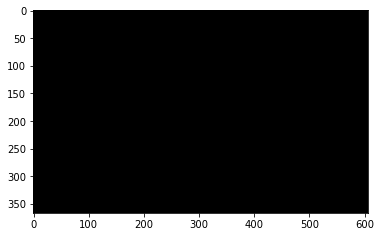

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


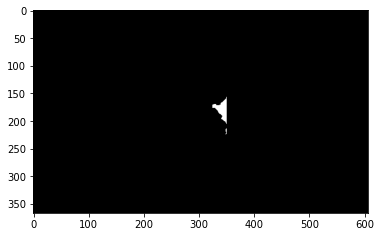

(4, 367, 607, 6, 6)
writing samples 452


100%|██████████| 452/452 [00:00<00:00, 109635.98it/s]


/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


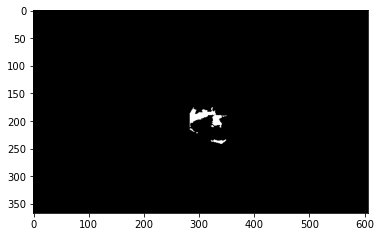

(4, 367, 607, 6, 6)
writing samples 833


100%|██████████| 833/833 [00:00<00:00, 114211.87it/s]




C
loading mask: C
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area2_2022-05-08_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: C
['/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_area2_info.pth']
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_area2_info.pth


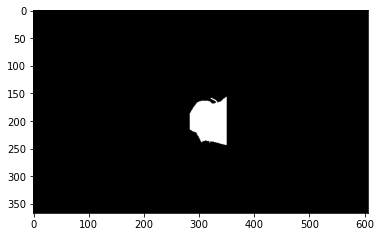

(4, 367, 607, 6, 6)
writing samples 4347


100%|██████████| 4347/4347 [00:00<00:00, 192080.23it/s]




C-Z
loading mask: C
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area2_2022-05-08_size_6_dammask.pth.tar
load img: C-Z
['/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_area2_info.pth', '/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_area2_info.pth']
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


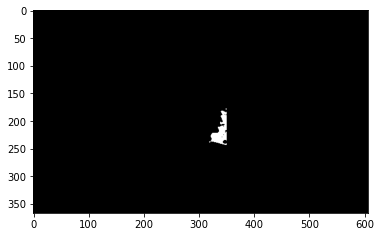

(4, 367, 607, 6, 6)
writing samples 742


100%|██████████| 742/742 [00:00<00:00, 117409.50it/s]


/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


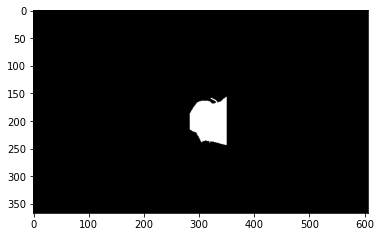

(4, 367, 607, 6, 6)
writing samples 4347


100%|██████████| 4347/4347 [00:00<00:00, 187185.74it/s]


/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


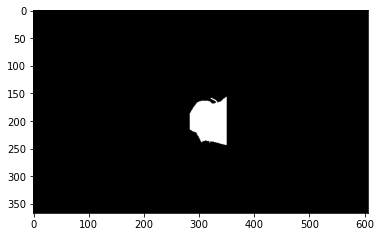

(4, 367, 607, 6, 6)
writing samples 4347


100%|██████████| 4347/4347 [00:00<00:00, 195233.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_area2_info.pth


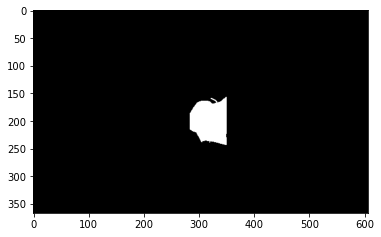

(4, 367, 607, 6, 6)
writing samples 4344


100%|██████████| 4344/4344 [00:00<00:00, 174660.47it/s]


/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


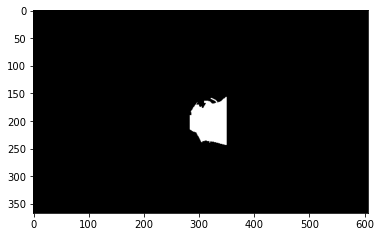

(4, 367, 607, 6, 6)
writing samples 4191


100%|██████████| 4191/4191 [00:00<00:00, 172836.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_area2_info.pth


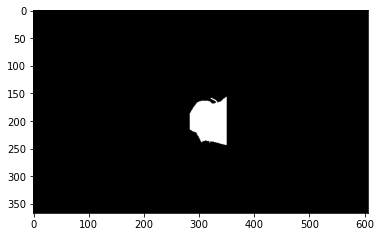

(4, 367, 607, 6, 6)
writing samples 4347


100%|██████████| 4347/4347 [00:00<00:00, 169795.49it/s]


/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_area2_info.pth


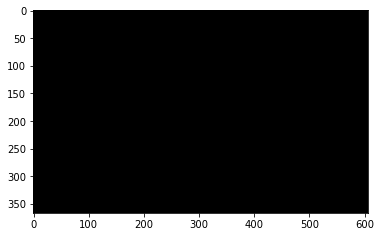

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_area2_info.pth


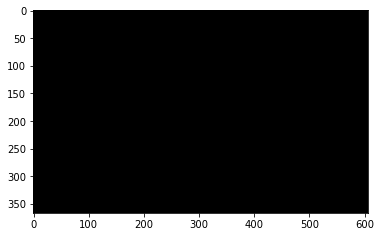

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


-------------------------------------
['A', 'A-B', 'B', 'B-Z']


A-B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: A-B
['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area3_info.pth']
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area3_info.pth


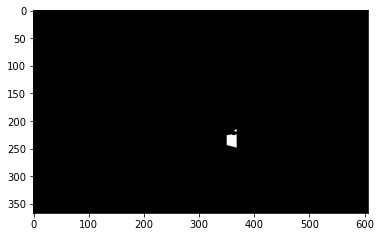

(4, 367, 607, 6, 6)
writing samples 343


100%|██████████| 343/343 [00:00<00:00, 104113.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area3_info.pth


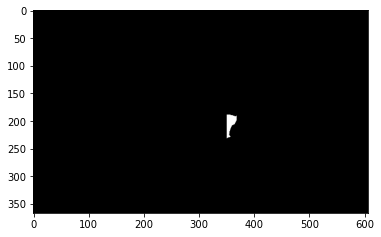

(4, 367, 607, 6, 6)
writing samples 396


100%|██████████| 396/396 [00:00<00:00, 93253.85it/s]




B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
load img: B
['/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area3_info.pth']
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


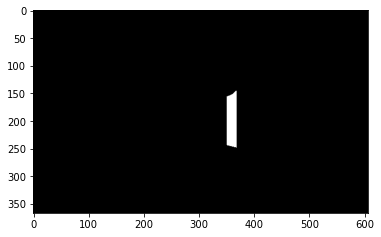

(4, 367, 607, 6, 6)
writing samples 1587


100%|██████████| 1587/1587 [00:00<00:00, 133028.77it/s]




B-Z
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
load img: B-Z
['/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_area3_info.pth', '/data4/Ukraine_img/M_and_L/20220602T082559_20220602T08280

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


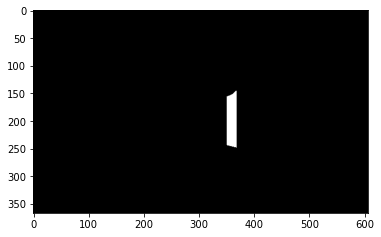

(4, 367, 607, 6, 6)
writing samples 1587


100%|██████████| 1587/1587 [00:00<00:00, 131579.83it/s]


/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


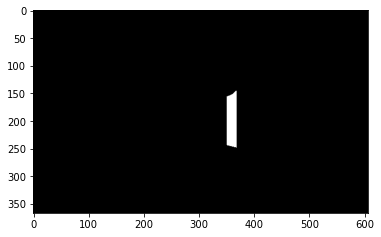

(4, 367, 607, 6, 6)
writing samples 1587


100%|██████████| 1587/1587 [00:00<00:00, 136664.08it/s]


/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


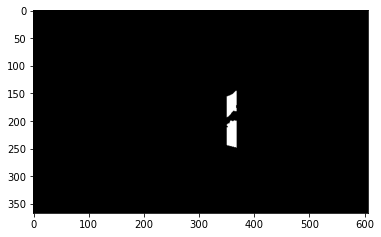

(4, 367, 607, 6, 6)
writing samples 1303


100%|██████████| 1303/1303 [00:00<00:00, 121505.10it/s]


/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area3_info.pth


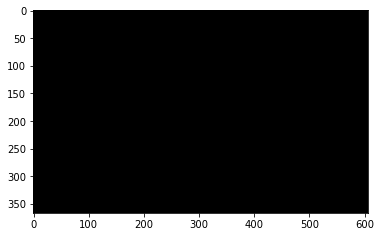

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area3_info.pth


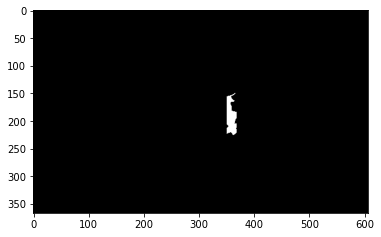

(4, 367, 607, 6, 6)
writing samples 866


100%|██████████| 866/866 [00:00<00:00, 118157.10it/s]


/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


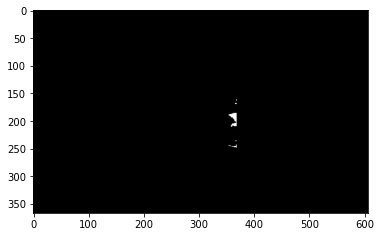

(4, 367, 607, 6, 6)
writing samples 142


100%|██████████| 142/142 [00:00<00:00, 88183.47it/s]


/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


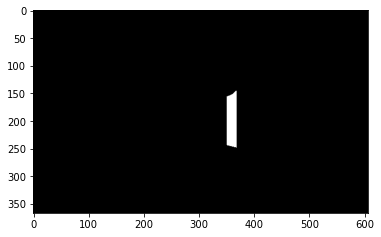

(4, 367, 607, 6, 6)
writing samples 1587


100%|██████████| 1587/1587 [00:00<00:00, 128921.78it/s]


/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


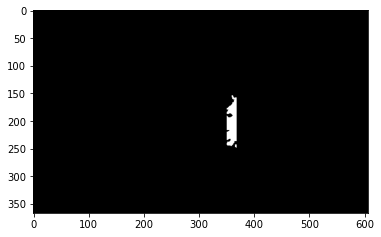

(4, 367, 607, 6, 6)
writing samples 1122


100%|██████████| 1122/1122 [00:00<00:00, 120192.29it/s]


/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


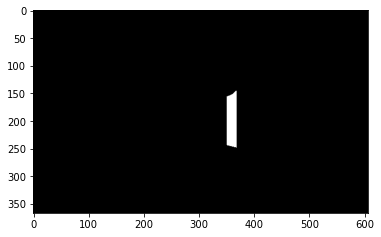

(4, 367, 607, 6, 6)
writing samples 1587


100%|██████████| 1587/1587 [00:00<00:00, 128070.97it/s]


/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


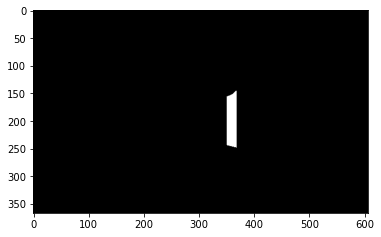

(4, 367, 607, 6, 6)
writing samples 1587


100%|██████████| 1587/1587 [00:00<00:00, 130955.96it/s]


/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


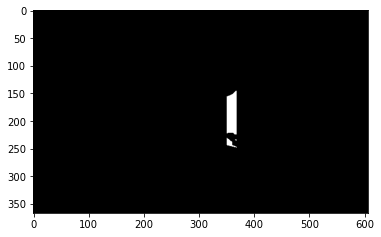

(4, 367, 607, 6, 6)
writing samples 1287


100%|██████████| 1287/1287 [00:00<00:00, 122558.05it/s]


/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


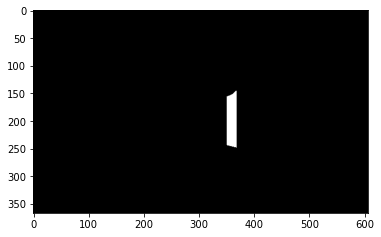

(4, 367, 607, 6, 6)
writing samples 1587


100%|██████████| 1587/1587 [00:00<00:00, 131177.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_area3_info.pth


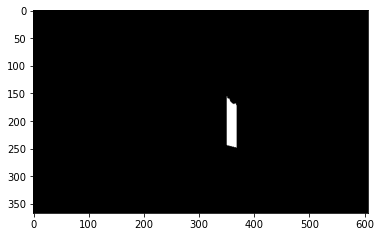

(4, 367, 607, 6, 6)
writing samples 1352


100%|██████████| 1352/1352 [00:00<00:00, 122981.98it/s]


/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_area3_info.pth


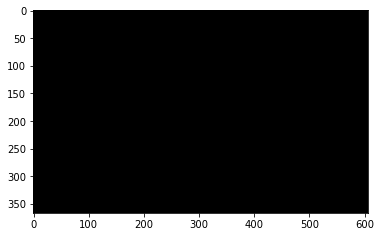

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_area3_info.pth


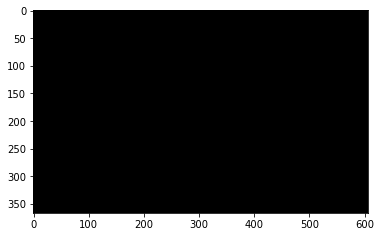

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


-------------------------------------
['A', 'A-B', 'B', 'B-C', 'C', 'C-Z']


A-B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: A-B
['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area4_info.pth']
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_area4_info.pth


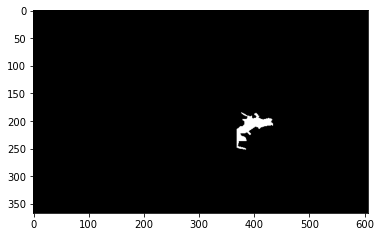

(4, 367, 607, 6, 6)
writing samples 1297


100%|██████████| 1297/1297 [00:00<00:00, 121915.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_area4_info.pth


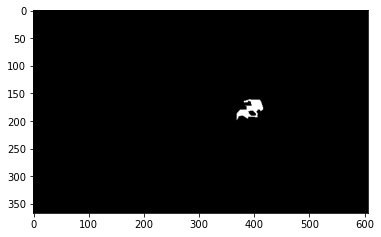

(4, 367, 607, 6, 6)
writing samples 742


100%|██████████| 742/742 [00:00<00:00, 112057.52it/s]




B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
load img: B
['/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area4_info.pth']
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


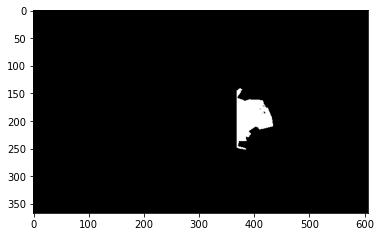

(4, 367, 607, 6, 6)
writing samples 3521


100%|██████████| 3521/3521 [00:00<00:00, 156879.28it/s]




B-C
loading mask: B and C
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1-4_2022-05-07_size_6_dammask.pth.tar
load img: B-C
['/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area4_info.pth']
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


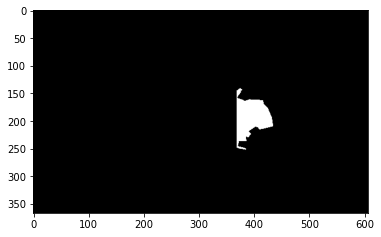

(4, 367, 607, 6, 6)
writing samples 3527


100%|██████████| 3527/3527 [00:00<00:00, 170853.04it/s]


/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


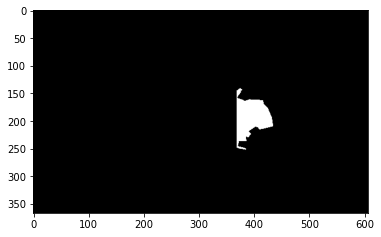

(4, 367, 607, 6, 6)
writing samples 3527


100%|██████████| 3527/3527 [00:00<00:00, 168661.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_area4_info.pth


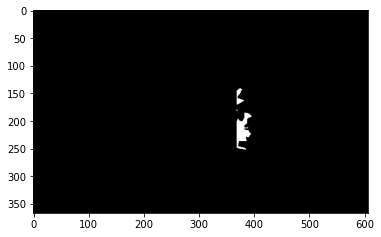

(4, 367, 607, 6, 6)
writing samples 962


100%|██████████| 962/962 [00:00<00:00, 112757.67it/s]


/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_area4_info.pth


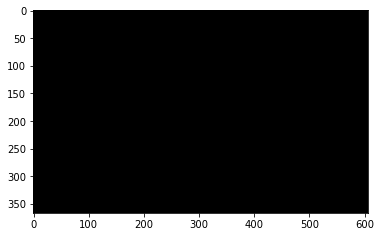

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_area4_info.pth


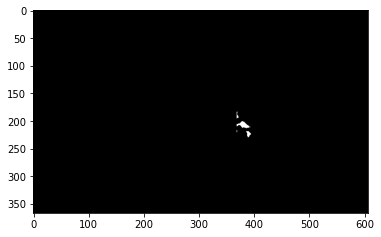

(4, 367, 607, 6, 6)
writing samples 172


100%|██████████| 172/172 [00:00<00:00, 86594.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_area4_info.pth


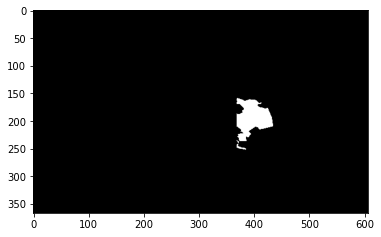

(4, 367, 607, 6, 6)
writing samples 2919


100%|██████████| 2919/2919 [00:00<00:00, 160012.20it/s]




C
loading mask: C
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1-4_2022-05-07_size_6_dammask.pth.tar


C-Z
loading mask: C
/data4/Ukraine_img/M_and_L/Livoberezhyny_C-Area1-4_2022-05-07_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: C-Z
['/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_area4_info.pth', '/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_area4_info.pth']
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_area4_info.pth


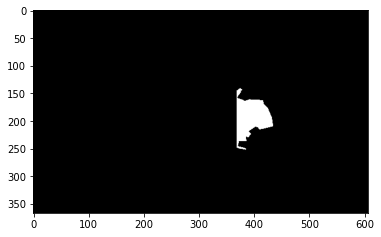

(4, 367, 607, 6, 6)
writing samples 3568


100%|██████████| 3568/3568 [00:00<00:00, 170127.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area4_info.pth


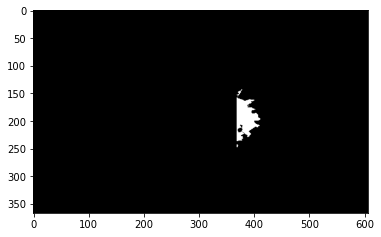

(4, 367, 607, 6, 6)
writing samples 1878


100%|██████████| 1878/1878 [00:00<00:00, 124917.18it/s]


/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


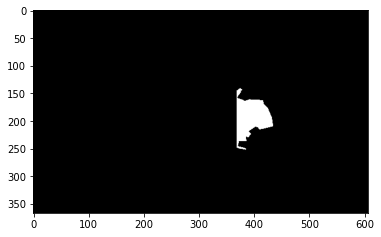

(4, 367, 607, 6, 6)
writing samples 3568


100%|██████████| 3568/3568 [00:00<00:00, 170528.92it/s]


/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


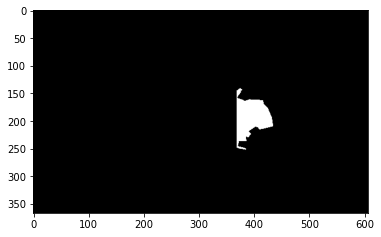

(4, 367, 607, 6, 6)
writing samples 3568


100%|██████████| 3568/3568 [00:00<00:00, 164922.99it/s]


/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


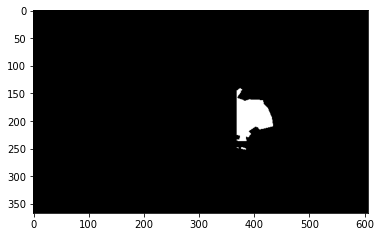

(4, 367, 607, 6, 6)
writing samples 3473


100%|██████████| 3473/3473 [00:00<00:00, 178955.73it/s]


/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


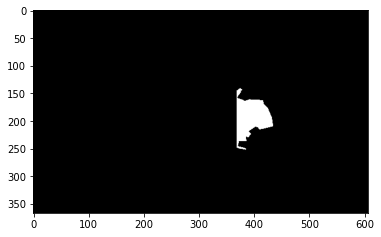

(4, 367, 607, 6, 6)
writing samples 3568


100%|██████████| 3568/3568 [00:00<00:00, 34690.51it/s]


/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


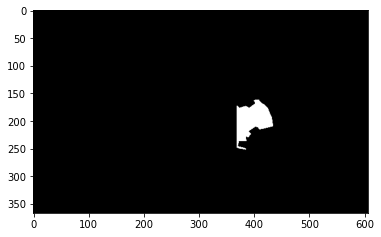

(4, 367, 607, 6, 6)
writing samples 3053


100%|██████████| 3053/3053 [00:00<00:00, 169313.90it/s]


/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_area4_info.pth


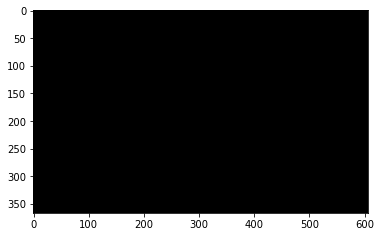

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_area4_info.pth


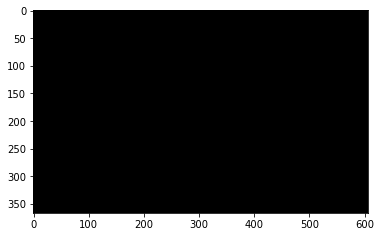

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


In [22]:
cities=dammasks_path.keys()
for city in cities:
    print('-------------------------------------')
    cityimg_pathes10=img_pathes[city]

    # print(city)
    masks10=dammasks_path[city]

    # print(masks)
    k_interval=list(cityimg_pathes10.keys())

    print(k_interval)
    k_interval.remove('A')
    for k_ in k_interval:
        print()
        print()
        print(k_)
        if len(k_)==1:
            print('loading mask:',k_)
            print(masks10[k_])
            mask_now=torch.load(masks10[k_])
            mask_before=None
            mask_after=None
        else:
            if 'A' in k_:
                print('loading mask:',k_[2])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=None
                mask_after=torch.load(masks10[k_[2]])
            elif 'Z' in k_:
                print('loading mask:',k_[0])
                print(masks10[k_[0]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=None
            else:
                print('loading mask:',k_[0],'and',k_[2])
                print(masks10[k_[0]])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=torch.load(masks10[k_[2]])  
        pre10_path=cityimg_pathes10['A'][0]
        pre_info=torch.load(pre10_path)
        pre_img=[pre_info['img10'],pre_info['img20']]
        post10_pathes=cityimg_pathes10[k_]
        if len(post10_pathes)==0:
            continue
        post10_pathes.sort()
        print('load img:',k_)
        print(post10_pathes)
        for post10_path in post10_pathes:
            print(post10_path)
            post_info=torch.load(post10_path)
            post_img=[post_info['img10'],post_info['img20']]
            plt.imshow(post_img[0][:3,:,:,1,1].transpose((1,2,0)))
            plt.show()
            samples,zz=get_samples(pre_img,post_img,mask_after,mask_now,mask_before)
            print('writing samples',len(samples))
            time.sleep(2)


            samples_root='/ssd/hk/Ukraine_samples/samplesv2/samples/'
            img_id=os.path.basename(post10_path).split('_size')[0].replace('_','-')

            samples_pathes=[samples_root+f'{city}_{img_id}_{str(i[0][0]).zfill(3)+str(i[0][1]).zfill(3)}.pth' for i in samples]
            info=[]

            for i in tqdm(range(len(samples))):
                    # '5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
                    info.append([samples_pathes[i],samples[i][0],samples[i][1]])
                    if not os.path.exists(samples_pathes[i]):
                        torch.save(samples[i],samples_pathes[i])
            info_dict={'readme':'4个字段\n 1:pre图像路径\n 2:post图像路径\n 3:图像坐标\n 4:损毁信息\n 损毁信息有5层\n 5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6', 'info':info}
            s_path=f'/ssd/hk/Ukraine_samples/samplesv2/{city}_{img_id}_add_afterC_nodam_samples_info.pth'

            torch.save(info_dict,s_path)
            # if post10_path=='/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth':
            #     raise

# 创建samples_slip文件

area1
/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area1_info.pth
t:3669   v:1574


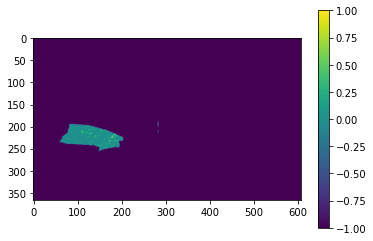

area2
/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area2_info.pth
t:3042   v:1305


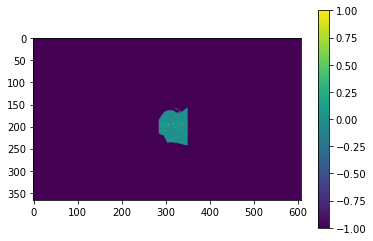

area3
/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area3_info.pth
t:1110   v:477


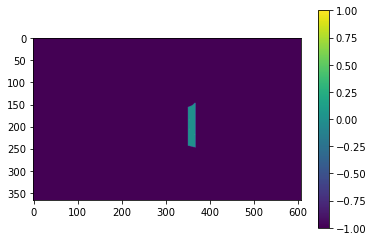

area4
/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area4_info.pth
t:2497   v:1071


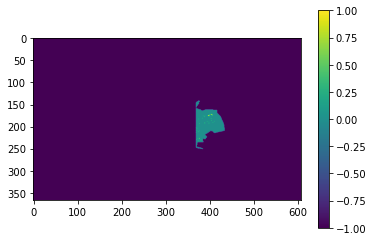

In [129]:
size=6
for city in cities:
    print(city)
    if 'C' in list(dammasks_path[city].keys()):
        dammask_path=dammasks_path[city]['C']
    else:
        dammask_path=dammasks_path[city]['B']

    dammask=torch.load(dammask_path)['mask'][0]
    # plt.imshow(dammask)
    # plt.show()
    mask_path=img_pathes[city]['A'][0]
    print(mask_path)
    mask=torch.load(mask_path)['img10'][0]
    mask[mask>0]=1
    # plt.imshow(mask[:,:,0,0])
    # plt.show()
    shape=mask.shape




    sample_mask=np.zeros((shape[0],shape[1]))
    sample_p=[]
    sample_n=[]
    for x in range(shape[0]):
        for y in range(shape[1]):
            if dammask[x,y]>0:
                sample_mask[x,y]=1
            if (mask[x,y]==0).any() and (mask[x,y]==0).any():
                sample_mask[x,y]=-1
            if sample_mask[x,y]==1:
                sample_p.append([x,y])
            elif sample_mask[x,y]==0:
                sample_n.append([x,y])

    p_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_p]
    n_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_n]
    random.shuffle(p_coord)
    random.shuffle(n_coord)
    p_t_coord=p_coord[:int(len(p_coord)*0.7)]
    p_v_coord=p_coord[int(len(p_coord)*0.7):]
    n_t_coord=n_coord[:int(len(n_coord)*0.7)]
    n_v_coord=n_coord[int(len(n_coord)*0.7):]
    t=p_t_coord+n_t_coord
    v=p_v_coord+n_v_coord
    random.shuffle(t)
    random.shuffle(v)
    print(f't:{len(t)}   v:{len(v)}')
    torch.save(t,f'/ssd/hk/Ukraine_samples/coords_splitv2/{city}_train.pth')
    torch.save(v,f'/ssd/hk/Ukraine_samples/coords_splitv2/{city}_val.pth')
    # plt.figure(figsize=(15,15))
    plt.imshow(sample_mask)
    plt.colorbar()
    plt.show()



In [23]:
def match(string,input_list):
    new_data_list=[i for i in input_list if  re.match(string, i[0]) != None]
    return new_data_list
t=[]
v=[]
city_sample=[]
for i in glob('/ssd/hk/Ukraine_samples/coords_splitv2/area*train.pth'):
    t+=torch.load(i)
    v+=torch.load(i.replace('train','val'))
print(len(t),len(v))
for i in glob('/ssd/hk/Ukraine_samples/samplesv2/*add_afterC_nodam_samples_info.pth'):
    city_sample+=torch.load(i)['info']
print(len(city_sample))

for i in range(len(city_sample)):
    if len(city_sample[i][2])==2:
        if city_sample[i][2][0] is not None:
            city_sample[i][2]=city_sample[i][2][0]
        else:
            city_sample[i][2]=city_sample[i][2][1]
city_pathes=[[i[0],'n'] if i[2][0]==0 else [i[0],'p'] for i in city_sample]
random.shuffle(city_pathes)
import re
city_coord_sample={}
city_coord_sample['train']={}
city_coord_sample['val']={}
print('match train')
time.sleep(2)
for i in tqdm(t):
    a=match(f'.*{i}.pth',city_pathes)
    a.sort()
    city_coord_sample['train'][i]=a
print('match val')
time.sleep(2)
for i in tqdm(v):
    a=match(f'.*{i}.pth',city_pathes)
    a.sort()
    city_coord_sample['val'][i]=a
torch.save(city_coord_sample,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/samples_add_afterC_nodam.pth') 



t=[]
for i in city_coord_sample['train'].keys():
    t+=city_coord_sample['train'][i]
v=[]
for i in city_coord_sample['val'].keys():
    v+=city_coord_sample['val'][i]
random.shuffle(t)
random.shuffle(v)
torch.save(t,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLaddafterC/train.pth') 
torch.save(v,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLaddafterC/val.pth') 

10318 4427
155952
match train


100%|██████████| 10318/10318 [30:16<00:00,  5.68it/s]


match val


100%|██████████| 4427/4427 [13:00<00:00,  5.67it/s]


In [30]:
for i in city_coord_sample['val'].keys():
    if len(city_coord_sample['val'][i])>20:
        print(i)
        break

In [33]:
print(len(t))
len([i  for i in t if i[1]=='n'])

109178


108007

In [34]:
print(len(v))
len([i  for i in v if i[1]=='n'])

46774


46263

In [61]:
import gdal
import torch
s=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLaddafterC/samples.pth')

In [62]:
tt=[]
for i in s['train'].keys():
    t_p=[j[0] for j in s['train'][i]]+[None]*(20-len(s['train'][i]))
    t_l=[j[1] for j in s['train'][i]]+[None]*(20-len(s['train'][i]))
    tt.append([t_p,t_l])
random.shuffle(tt)
print(len(tt))

10318


In [39]:
torch.save(tt,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MLaddafterC/val.pth')

In [57]:
len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/ML/train.pth'))


10318

In [50]:
tt=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MLaddafterC/train.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Azovstal/train.pth')
random.shuffle(tt)
len(tt)

12879

In [51]:
torch.save(tt,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MaddafterC/train.pth')